In [1]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import cbc, numpy as np, scipy as sp, matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
waist = 1.2e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 100, 100, 1
detNx, detNy = 128, 128
pix_size = 55e-3
det_dist = 30

# Gaussian beam

In [2]:
def thdiv(waist, wavelength):
    return wavelength / np.pi / waist

def zR(waist, wavelength):
    return np.pi * waist**2 / wavelength

def R(zs, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    return zs + zr**2 / zs

def wz(z, waist, wavelength):
    return waist * np.sqrt(1 + (z / zR(waist, wavelength)**2))

def gaussian(xs, ys, zs, waist=1e-4, wavelength=1.5e-7):
    k = 2 * np.pi / wavelength
    zr = np.pi * waist**2 / wavelength
    Rs = zs + zr**2 / zs
    wz = waist * sqrt(1 + z**2 / zr**2)
    return np.pi**-1 * waist**-1 * wz**-1 * np.exp(-(xs**2 + ys**2) / wz**2) * np.exp(-1j * (k * z - np.arctan(zs / zr) + k * (xs**2 + ys**2) / 2 / Rs))

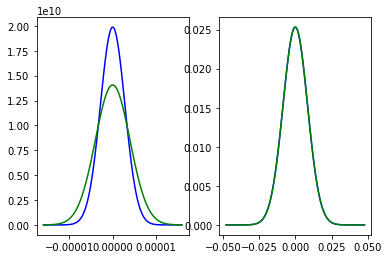

In [50]:
%matplotlib inline
xs = np.linspace(-4 * waist, 4 * waist, 100)
us = np.abs(cbc.gaussian(xs, 0, 0, waist, wavelength))
us2 = np.abs(cbc.gaussian(xs, 0, zR(waist, wavelength), waist, wavelength))
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength), 100)
ufs = np.abs(cbc.gaussian_f(kxs, 0, 0, waist, wavelength))
ufs2 = np.abs(cbc.gaussian_f(kxs, 0, zR(waist, wavelength), waist, wavelength))
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(xs, us, 'b-', xs, us2, 'g-')
ax2.plot(kxs, ufs, 'b-', kxs, ufs2, 'g-')
plt.show()

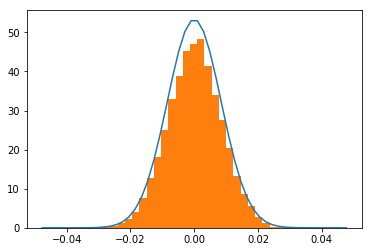

In [34]:
%matplotlib inline
knum = 10000
ks = cbc.gaussian_dist(knum, 0, waist, wavelength)
kxs = np.linspace(-4 * thdiv(waist, wavelength), 4 * thdiv(waist, wavelength))
us = np.abs(cbc.gaussian_f(kxs, 0, 10, waist, wavelength)) * 4 * np.pi / thdiv(waist, wavelength)*2
plt.plot(kxs, us)
plt.hist(ks[:,0], 30, density=True)
plt.show()

In [ ]:
%matplotlib inline
_thdiv = thdiv(waist,wavelength)
kxs, kys = cbc.uniform_dist(100000, waist, wavelength)[:, 0:2].T
kxs2, kys2 = cbc.gaussian_dist(100000, waist, wavelength)[:, 0:2].T
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.hist2d(kxs, kys, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
ax2.hist2d(kxs2, kys2, 20, range=[[-2*_thdiv,2*_thdiv],[-2*_thdiv,2*_thdiv]])
plt.show()

# Convolution approximation and Henry's equations

In [36]:
def gaus_dist(kxs, kys, waist, wavelength):
    thdiv = wavelength / np.pi / waist
    return np.pi**-1 * thdiv**-2 * np.exp(-(kxs**2 + kys**2) / thdiv**2)

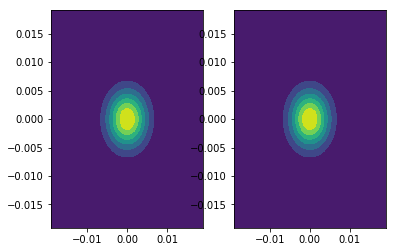

In [37]:
%matplotlib inline
knum = 100000
mus = np.zeros(2)
sigma = thdiv(waist, wavelength)
cov = [[sigma**2 / 2, 0], [0, sigma**2 / 2]]
rv = sp.stats.multivariate_normal(mean=mus, cov=cov)
_kxs = np.linspace(-4 * sigma, 4 * sigma)
kxs, kys = np.meshgrid(_kxs, _kxs)
ks = np.empty(kxs.shape + (2,))
ks[:, :, 0] = kxs; ks[:, :, 1] = kys
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.contourf(kxs, kys, gaus_dist(kxs, kys, waist, wavelength))
ax2.contourf(kxs, kys, rv.pdf(ks))

In [3]:
def gaussian_dist(N, z, waist, wavelength):
    zr = np.pi * waist**2 / wavelength
    wz = waist * np.sqrt(1 + z**2 / zr**2)
    thdiv = wavelength / np.pi / wz
    kxs, kys = np.random.multivariate_normal([0, 0], [[thdiv**2 / 2, 0], [0, thdiv**2 / 2]], N).T
    return cbc.kout_parax(kxs, kys)

In [3]:
waist = 3e-6
wavelength = 1.5e-7
a, b, c = 2e-6, 2.5e-6, 1e-5
Nx, Ny, Nz = 10, 10, 1
detNx, detNy = 64, 64
pix_size = 2 * 55e-3
det_dist = 30
knum = 5000

In [4]:
%matplotlib inline
XS, YS, ZS = np.array([0, 0.5 * a]), np.zeros(2), np.zeros(2)
els = ['Au', 'Ag']; bs = np.zeros(2)
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz, XS, YS, ZS)
z0 = 1e-4
zs += z0
asf_coeffs = cbc.asf_coeffs(els, bs)
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
kins = cbc.gaussian_kins(xs, ys, zs, waist, wavelength)
us = cbc.gaussian(xs, ys, zs, waist, wavelength) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)
print(asf_coeffs.shape)

(2, 11)


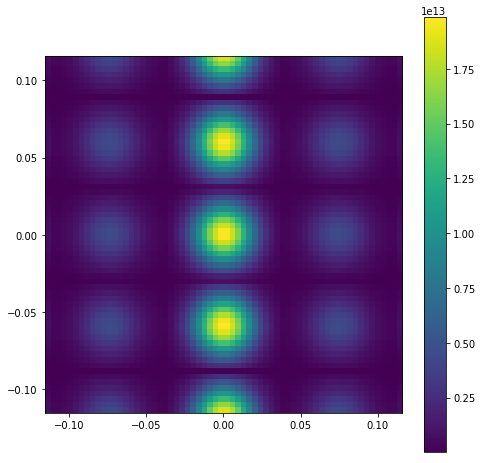

In [80]:
qabs = cbc.utils.q_abs(kouts, kins, wavelength)
asfs = cbc.utils.asf_sum(qabs, asf_coeffs)
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs * us * phs).sum(axis=(-2,-1)).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(8, 8))
plt.imshow(ints, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

In [81]:
%time kjs = np.repeat(cbc.gaussian_dist(knum, waist, wavelength)[:,np.newaxis], xs.shape[-1], axis=1)
%time qabs2 = cbc.utils.q_abs(kouts, kjs, wavelength)
%time asfs2 = cbc.utils.asf_sum(qabs2, asf_coeffs)
%time phs2 = cbc.utils.phase_conv(kouts, kjs, xs, ys, zs, wavelength)
%time sfs2 = asfs2 * phs2
print(kjs.shape, qabs2.shape, asfs2.shape, phs2.shape)

CPU times: user 1.13 ms, sys: 533 µs, total: 1.66 ms
Wall time: 1.13 ms
CPU times: user 480 ms, sys: 203 ms, total: 683 ms
Wall time: 680 ms
CPU times: user 2.03 s, sys: 102 ms, total: 2.13 s
Wall time: 2.12 s
CPU times: user 1min 16s, sys: 416 ms, total: 1min 17s
Wall time: 1min 16s
CPU times: user 248 ms, sys: 197 ms, total: 445 ms
Wall time: 443 ms
(5000, 2, 3) (4096, 5000, 2) (4096, 5000, 2) (4096, 5000, 2)


In [82]:
uphs = cbc.gaussian_f(kjs[:,:,0], kjs[:,:,1], z0, waist, wavelength)
res2 = (uphs * sfs2).sum(axis=(-2,-1)).reshape(kxs.shape) / kjs.shape[0]
print(uphs.shape, res2.shape)

(5000, 2) (64, 64)


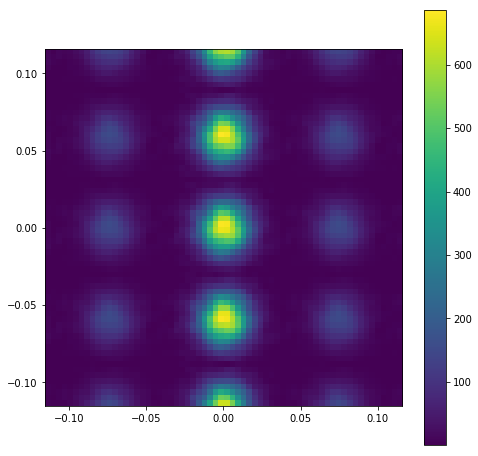

In [83]:
ints2 = np.abs(res2)
plt.figure(figsize=(8, 8))
plt.imshow(ints2, extent=[kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

# PDB structure factor

In [88]:
import numba as nb
from math import sqrt, cos, sin, exp, pi

In [89]:
xs, ys, zs, bs, els = [], [], [], [], []
for line in open('../cbc/utils/pdb/4et8.pdb'):
    if line.startswith("ATOM"):
            xs.append(float(line[31:38]))
            ys.append(float(line[39:46]))
            zs.append(float(line[47:54]))
            bs.append(float(line[61:66]))
            els.append(line[77:78])
asf_coeffs = cbc.asf_coeffs(els, bs)
xs = np.array(xs); ys = np.array(ys); zs = np.array(zs); bs = np.array(bs)

@nb.njit(nb.complex128[:](nb.float64[:,:], nb.float64[:,:], nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:]), fastmath=True)
def sf_sum(ss, acoeffs, bcoeffs, xs, ys, zs, bs):
    a = ss.shape[0]
    b, c = acoeffs.shape
    sfs = np.empty(a, dtype=np.complex128)
    ss = np.ascontiguousarray(ss)
    acoeffs = np.ascontiguousarray(acoeffs)
    bcoeffs = np.ascontiguousarray(bcoeffs)
    for i in range(a):
        dsf = 0.0j
        sabs = ss[i,0]**2 + ss[i,1]**2 + ss[i,2]**2
        for j in range(b):
            dasf = 0.0
            ph = 4 * pi * (ss[i,0] * xs[j] + ss[i,1] * ys[j] + ss[i,2] * zs[j])
            for k in range(c):
                dasf += acoeffs[j,k] * exp(-sabs * bcoeffs[j,k])
            dsf += dasf * (cos(ph) + 1j * sin(ph)) * exp(-bs[j] * sabs)
        sfs[i] = dsf
    return sfs

def sf(ss, asf_coeffs, xs, ys, zs, bs):
    acoeffs, bcoeffs = asf_coeffs[:, :5], asf_coeffs[:, 6:]
    return sf_sum(ss.reshape(-1, ss.shape[-1]), acoeffs, bcoeffs, xs, ys, zs, bs).reshape(ss.shape[:-1])

In [169]:
wavelength = 1.5e-7
f, ap, defoc = 2, 2e-2, 1e-4
waist = 4.5e-6
a, b, c = 7.9e-6, 7.9e-6, 3.8e-6
Nx, Ny, Nz = 20, 20, 1
detNx, detNy = 512, 512
pix_size = 55e-3 / 2
det_dist = 30

In [170]:
print(wavelength / a, 2 * ap / f, 2 * wavelength / np.pi / waist)

0.018987341772151896 0.02 0.021220659078919377


In [4]:
beam = cbc.CircBeam(f, ap, wavelength)
diff = cbc.Diff(beam=beam,
                det_args=cbc.DetArgs(det_dist=det_dist, detNx=detNx, detNy=detNy, pix_size=pix_size),
                cell_args=cbc.CellArgs.importpdb('4et8.pdb'),
                lat_args=cbc.LatArgs(a=a, b=b, c=c, Nx=Nx, Ny=Ny, Nz=Nz))
diff.move_lat([0.501 * a, 0.501 * b, 1e-4])

In [74]:
import h5py

In [75]:
f = h5py.File('../results/diff_04-04-2019_15-14-34.hdf5', 'r')
results = f['results']
data = []
for key in results.keys():
    data.append(results[key][:])
f.close()

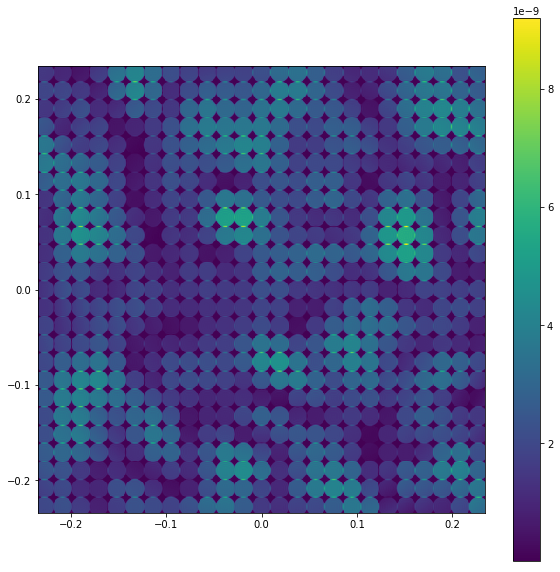

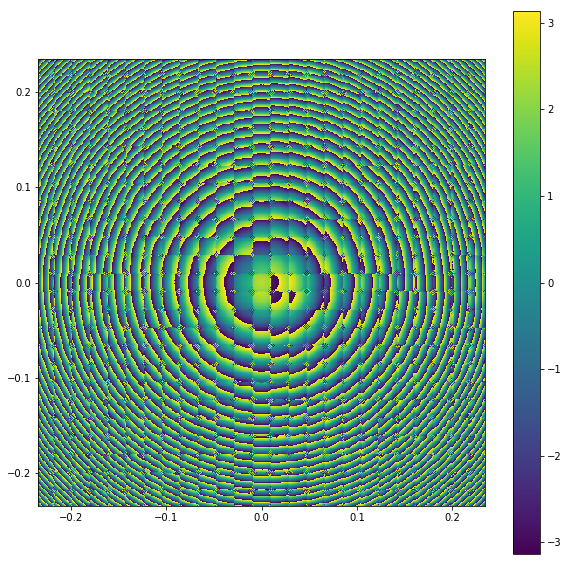

In [76]:
ints = np.abs(data[0])
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()
ang1 = np.angle(data[0])
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

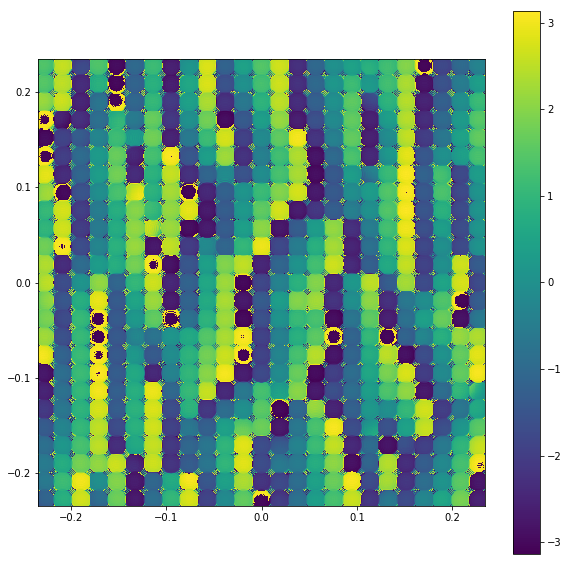

In [157]:
ang2 = np.angle(data[0] / np.exp(2j * np.pi / wavelength * 1e-4 * (1 - (data[1]**2 + data[2]**2) / 2)))
plt.figure(figsize=(10,10))
plt.imshow(ang2, extent = [data[1].min(), data[1].max(), data[2].min(), data[2].max()])
plt.colorbar()
plt.show()

# Structure factor plotting

In [93]:
import numba as nb
from math import exp, cos, sin, pi

In [94]:
@nb.njit(nb.float64[:,:](nb.float64[:], nb.float64[:,:]), fastmath=True)
def asf_sum(ss, asfcoeffs):
    a = ss.size
    b = asfcoeffs.shape[0]
    asfs = np.empty((a, b), dtype=np.float64)
    ss = np.ascontiguousarray(ss)
    asfcoeffs = np.ascontiguousarray(asfcoeffs)
    for i in range(a):
        for j in range(b):
            dasf = 0.0
            for k in range(5):
                dasf += asfcoeffs[j,k] * exp(-ss[i]**2 * asfcoeffs[j,6+k])
            asfs[i,j] = (dasf + asfcoeffs[j,5]) * exp(-ss[i]**2 * asfcoeffs[j,-1])
    return asfs

@nb.njit(nb.complex128[:,:](nb.float64[:,:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64), fastmath=True)
def phase(kouts, xs, ys, zs, wavelength):
    a = kouts.shape[0]
    b = xs.size
    res = np.empty((a, b), dtype=np.complex128)
    kouts = np.ascontiguousarray(kouts)
    xs = np.ascontiguousarray(xs)
    ys = np.ascontiguousarray(ys)
    zs = np.ascontiguousarray(zs)
    for i in range(a):
        for j in range(b):
            _ph = kouts[i,0] * xs[j] + kouts[i,1] * ys[j] + kouts[i,2] * zs[j]
            res[i,j] = cos(2 * pi / wavelength * _ph) + sin(2 * pi / wavelength * _ph) * 1j
    return res

In [106]:
H, K = 10, 10

In [147]:
gxs, gys = cbc.det_kouts(det_dist=1/wavelength, detNx=2*H+1, detNy=2*K+1, pix_size=1/a)
ss = np.sqrt(gxs**2 + gys**2) / wavelength / 2e7
gs = cbc.kout_parax(gxs.ravel(), gys.ravel())
XS, YS, ZS, bs, elems = cbc.utils.pdb.importpdb('4et8.pdb')
asfcoeffs = cbc.asf_coeffs(elems, bs, wavelength)
asfs = asf_sum(ss.ravel(), asfcoeffs)
phs = phase(gs, XS, YS, ZS, wavelength)
Fs = (asfs * phs).sum(axis=-1).reshape(gxs.shape)
print(asfs.shape, phs.shape, Fs.shape)

(441, 1001) (441, 1001) (21, 21)


In [148]:
lim = slice((detNx - int(gxs.max() / data[1].max() * detNx)) // 2, (detNx + int(gxs.max() / data[1].max() * detNx)) // 2)

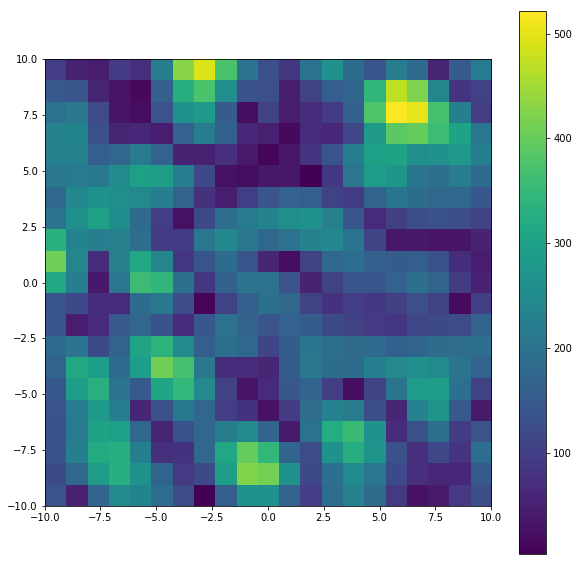

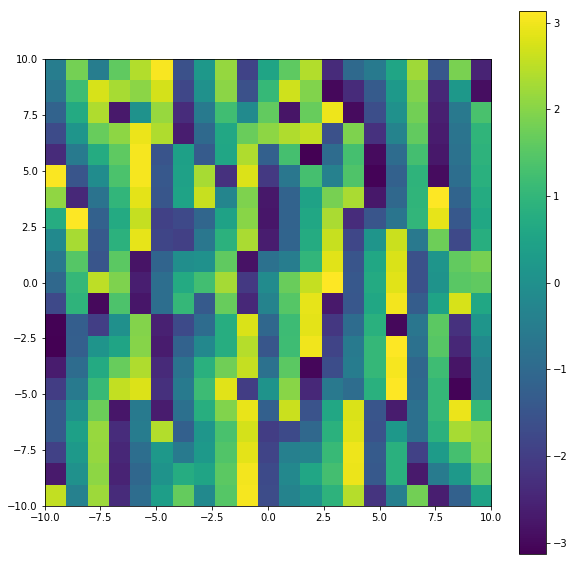

In [152]:
ints2 = np.abs(Fs)
plt.figure(figsize=(10,10))
plt.imshow(ints2, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()
ang3 = np.angle(Fs)
plt.figure(figsize=(10,10))
plt.imshow(ang4, extent=[-H,H,-K,K])
plt.colorbar()
plt.show()

# Lens beam

In [2]:
from numba.extending import get_cython_function_address
from numba import njit, cfunc, carray, vectorize
from numba.types import float64, complex128, intc, CPointer, UniTuple
from math import cos, sin, pi, sqrt, exp
import ctypes, scipy.integrate as si
from scipy import LowLevelCallable, special

In [14]:
wavelength = 1.5e-7
f, ap, defoc = 2, 8e-2, 1e-4
a, b, c = 2e-6, 2e-6, 1e-5
Nx, Ny, Nz = 60, 60, 1
detNx, detNy = 128, 128
pix_size = 55e-3 / 2
det_dist = 30

In [ ]:
np.exp(2j * np.pi / wavelength * np.subtract.outer(kouts[:,0], kins[:,0]) * a / 4.0).shape

In [15]:
print(wavelength / a, 2 * ap / f)

0.075 0.08


In [16]:
addr = get_cython_function_address("scipy.special.cython_special", "j0")
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
j0 = functype(addr)

@vectorize('float64(float64)')
def j0_vec(x):
    return j0(x)

@njit
def j0_in_njit(x):
    return j0_vec(x)

def jit_integrand(func):
    jit_func = njit(func)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapper(n, args):
        return jit_func(args[0], args[1], args[2], args[3], args[4])
    return LowLevelCallable(wrapper.ctypes)

def quad_complex(func_re, func_im, a, b, **args):
    re = si.quad(func_re, a, b, **args)[0]
    im = si.quad(func_im, a, b, **args)[0]
    return re + 1j * im

@jit_integrand
def rect_re(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return cos(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

@jit_integrand
def rect_im(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return -sin(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

@jit_integrand
def circ_re(rr, r, z, f, wavelength):
    k = 2 * np.pi / wavelength
    return cos(k * rr**2 / 2 * (1 / f - 1 / z)) * j0_in_njit(k * r * rr / z) * 2 * pi * rr

@jit_integrand
def circ_im(rr, r, z, f, wavelength):
    k = 2 * np.pi / wavelength
    return -sin(k * rr**2 / 2 * (1 / f - 1 / z)) * j0_in_njit(k * r * rr / z) * 2 * pi * rr

@jit_integrand
def drect_re(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return (x - xx) * cos(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

@jit_integrand
def drect_im(xx, x, z, f, wavelength):
    k = 2 * pi / wavelength
    return (xx - x) * sin(k * xx**2 / 2 * (1 / f - 1 / z) + k / z * x * xx)

def drbeam(xs, ys, zs, f, a, wavelength):
    dxvals = np.array([quad_complex(drect_re, drect_im, -a, a, args=(x, z + f, f, wavelength), limit=10000) for x, z in zip(xs, zs)])
    dyvals = np.array([quad_complex(drect_re, drect_im, -a, a, args=(y, z + f, f, wavelength), limit=10000) for y, z in zip(ys, zs)])
    xvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(x, z + f, f, wavelength), limit=10000) for x, z in zip(xs, zs)])
    yvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(y, z + f, f, wavelength), limit=10000) for y, z in zip(ys, zs)])
    return (dxvals / xvals / zs , dyvals / yvals / zs)

def rbeam(xs, ys, zs, f, a, wavelength):
    k = 2 * np.pi / wavelength
    coeffs = -1j * np.exp(1j * k * (zs + f)) / wavelength / (zs + f) * np.exp(1j * k / 2 / (zs + f) * (xs**2 + ys**2))
    xvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(x, z + f, f, wavelength), limit=10000) for x, z in zip(xs, zs)])
    yvals = np.array([quad_complex(rect_re, rect_im, -a, a, args=(y, z + f, f, wavelength), limit=10000) for y, z in zip(ys, zs)])
    return coeffs * xvals * yvals

def cbeam(xs, ys, zs, f, a, wavelength):
    k = 2 * np.pi / wavelength
    coeffs = -1j * np.exp(1j * k * (zs + f)) / wavelength / (zs + f) * np.exp(1j * k * (xs**2 + ys**2) / 2.0 / (zs + f))
    rvals = np.array([quad_complex(circ_re, circ_im, 0, a, args=(sqrt(x**2 + y**2), z + f, f, wavelength), limit=10000) for x, y, z in zip(xs, ys, zs)])
    return coeffs * rvals

def simpsons(grid, dx):
    simv = np.empty(grid.shape[-1], dtype=np.float64)
    simv[[0,-1]] = 1.0
    simv[1:-1:2] = 4.0
    simv[2:-1:2] = 2.0
    print(simv)
    return dx / 3 * (simv * grid).sum(axis=-1)

def simpsons2d(grid, dx, dy):
    simv = np.empty(grid.shape[-1], dtype=np.float64)
    simv[[0,-1]] = 1.0
    simv[1:-1:2] = 4.0
    simv[2:-1:2] = 2.0
    simm = simv[:, np.newaxis] * simv
    return dx * dy / 9.0 * (simm * grid).sum(axis=(-2,-1))

In [17]:
xs, ys, zs = cbc.lattice(a, b, c, Nx, Ny, Nz)
zs = np.repeat(1e-4, Nx * Ny)
xs -= 0.501 * a
ys -= 0.501 * b
kxs, kys = cbc.det_kouts(det_dist, detNx, detNy, pix_size)
_kxs, _kys = kxs.ravel(), kys.ravel()
kouts = cbc.kout_parax(_kxs, _kys)
Rs = np.sqrt(xs**2 + ys**2 + zs**2)
kins = np.dstack((xs / Rs, ys / Rs, 1.0 - (xs**2 + ys**2) / 2.0 / Rs**2))[0]
us = cbeam(xs, ys, zs, f, ap, wavelength)

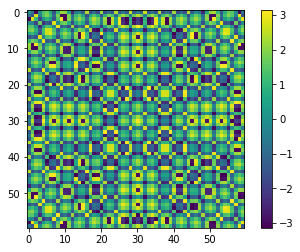

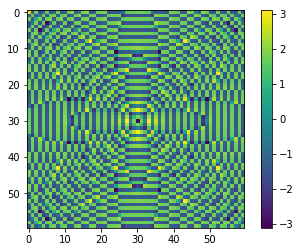

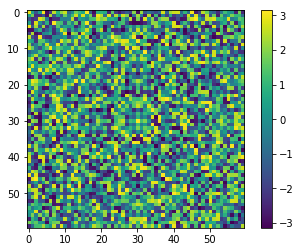

In [18]:
phin1 = (np.exp(1j) * cbc.utils.phase_inc(kins, xs, ys, zs, wavelength)).reshape((Nx, Ny))
angs1 = np.angle(phin1)
angs2 = np.angle(np.exp(1j * np.pi) * np.exp(-1j * np.pi * 1e-2 / wavelength * (xs**2 + ys**2) / Rs**2)).reshape((Nx, Ny))
angs3 = -np.angle(us).reshape(Nx, Ny)
plt.imshow(angs1)
plt.colorbar()
plt.show()
plt.imshow(angs3)
plt.colorbar()
plt.show()
plt.imshow(angs2)
plt.colorbar()
plt.show()

In [19]:
qs_abs = cbc.utils.q_abs(kouts, kins, wavelength)
asf_coeffs1 = cbc.asf_coeffs()
%time asfs1 = cbc.asf_vals(qs_abs, asf_coeffs1)
qs_abs.shape

CPU times: user 2.81 s, sys: 277 ms, total: 3.09 s
Wall time: 3.08 s


(16384, 3600)

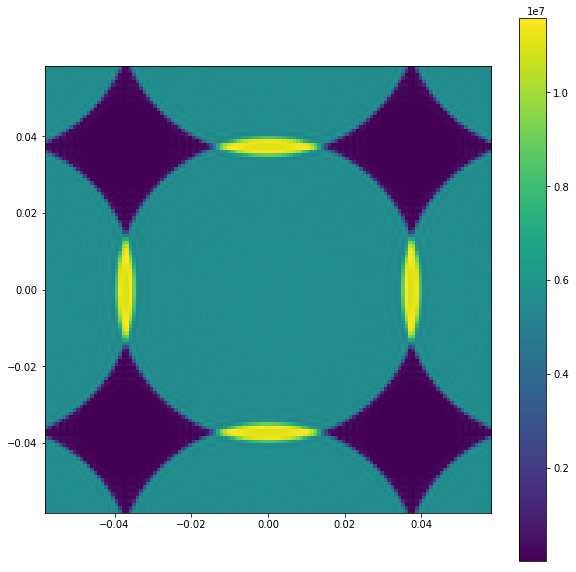

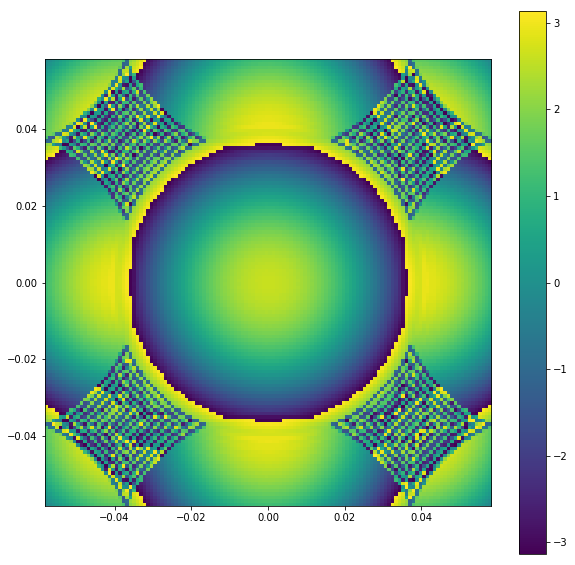

In [20]:
%matplotlib inline
phs = cbc.utils.phase(kouts, xs, ys, zs, wavelength)
res = (asfs1 * phs * us).sum(axis=-1).reshape(kxs.shape)
ints = np.abs(res)
plt.figure(figsize=(10, 10))
plt.imshow(ints, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()
ang1 = np.angle(res)
plt.figure(figsize=(10,10))
plt.imshow(ang1, extent = [kxs.min(), kxs.max(), kys.min(), kys.max()])
plt.colorbar()
plt.show()

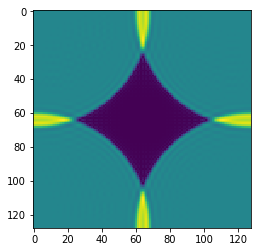

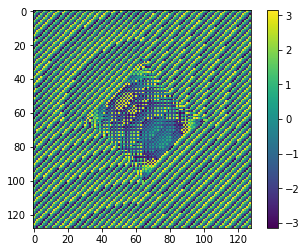

In [21]:
res2 = np.fft.fft2(us.reshape((Nx, Ny)), kxs.shape)
ints2 = np.abs(res2)
plt.imshow(ints2)
plt.show()
ang2 = np.angle(res2)
plt.imshow(ang2)
plt.colorbar()
plt.show()